<a href="https://colab.research.google.com/github/koreahong/parking_lot_analysis/blob/main/%EC%A3%BC%EC%B0%A8%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 과정중 발생한 문제 / 해결방법
row 삭제하고 나서 index를 다시 설정해야 apply함수 적용시킬때 문제가 안생김

# 문제정의

문제
-  주차수요예측: 등록차량수가 어느정도 될 것인가

컬럼 
- 단지코드
- 총세대수
- 임대건물구분
- 지역
- 공급유형
- 전용면적
- 전용면적별세대수
- 공가수
- 신분
- 임대료보증금
- 임대료
- 도보 10분거리 내 지하철역 수(환승노선 수 반영)
- 도보 10분거리 내 버스정류장 수
- 단지내주차면수
- 등록차량수 (예측)



# 자료 
  - [참고자료1](https://biz.chosun.com/real_estate/real_estate_general/2021/05/12/2C3EFUDZOFG55LHLD3BKRCVYNI/) - 2030세대 소형, 초소형 아파트에 몰림

- [참고자료2](https://www.carisyou.com/magazine/STATS/76374) - 50대에 가까워질수록 차구매를 많이함 / 중고자동차는 2030세대

In [ ]:
#download pont
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import numpy as np
import copy

#시각화
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

#통계
from scipy.stats import skew

#데이터전처리
from sklearn.preprocessing import OneHotEncoder

#머신러닝 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

#경고무시
import warnings
warnings.filterwarnings("ignore")

#폰트설정
plt.rc('font', family='NanumBarunGothic') 

#데이터 수집

- 구글 드라이브 연동 후 알집 풀기


In [ ]:
#mount google drive 
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#path setting, you must use '%' command
%cd "/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/"
#unzip
!unzip -qq "/content/drive/MyDrive/머신러닝_실전예제/Dacon_주차수요예측/data/parking_data.zip"

/content/drive/MyDrive/머신러닝_실전예제/Dacon_주차수요예측


In [ ]:
raw_train = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/train.csv")

In [ ]:
raw_test = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/test.csv")

In [ ]:
raw_train.head()

In [ ]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

In [ ]:
raw_test.info()

In [ ]:
age_info = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/age_gender_info.csv")

In [ ]:
age_info.head()

In [ ]:
age_info.info()

## obect type인것들 unique로 간략하게 보자

In [ ]:
oject_index = raw_train.dtypes[raw_train.dtypes == 'object'].index
oject_index

Index(['단지코드', '임대건물구분', '지역', '공급유형', '자격유형', '임대보증금', '임대료'], dtype='object')

임대보증금과, 임대료는 숫자형으로 교체  
null값이 있음 -> 추후 null값 처리
2컬럼을 제외한 나머지만 갑 확인

In [ ]:
for col in oject_index[:-2]:
  print(f"col: {col}, \n {raw_train[col].unique()} \n")

col: 단지코드, 
 ['C2483' 'C2515' 'C1407' 'C1945' 'C1470' 'C1898' 'C1244' 'C1171' 'C2073'
 'C2513' 'C1936' 'C2049' 'C2202' 'C1925' 'C2576' 'C1312' 'C1874' 'C2650'
 'C2416' 'C2013' 'C1424' 'C2100' 'C2621' 'C2520' 'C2319' 'C1616' 'C1704'
 'C2258' 'C1032' 'C2038' 'C1859' 'C1722' 'C1850' 'C2190' 'C1476' 'C1077'
 'C1068' 'C1983' 'C2135' 'C2034' 'C1109' 'C1497' 'C2289' 'C2597' 'C2310'
 'C1672' 'C2132' 'C1439' 'C1613' 'C2216' 'C1899' 'C1056' 'C2644' 'C1206'
 'C2481' 'C1718' 'C1655' 'C1430' 'C1775' 'C1519' 'C2221' 'C1790' 'C2109'
 'C1698' 'C1866' 'C1005' 'C1004' 'C1875' 'C2156' 'C2212' 'C2401' 'C2571'
 'C1175' 'C1833' 'C2445' 'C1885' 'C2368' 'C2016' 'C2371' 'C2536' 'C2538'
 'C1014' 'C1592' 'C1867' 'C2326' 'C1015' 'C1620' 'C1049' 'C2000' 'C2097'
 'C1668' 'C1689' 'C1234' 'C2514' 'C1368' 'C1057' 'C2336' 'C1026' 'C2256'
 'C1900' 'C2666' 'C2361' 'C1642' 'C1013' 'C2232' 'C1973' 'C2458' 'C2574'
 'C2133' 'C2096' 'C2010' 'C1879' 'C1131' 'C1468' 'C1213' 'C1173' 'C2492'
 'C2032' 'C2094' 'C1880' 'C2089' 'C174

In [155]:
 raw_train[raw_train.dtypes[raw_train.dtypes != 'object'].index]

,총세대수,전용면적,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,900,39.72,134,38.0,0.0,3.0,1425.0,1015.0
1,900,39.72,15,38.0,0.0,3.0,1425.0,1015.0
2,900,51.93,385,38.0,0.0,3.0,1425.0,1015.0
3,900,51.93,15,38.0,0.0,3.0,1425.0,1015.0
4,900,51.93,41,38.0,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...
2947,239,49.20,19,7.0,0.0,1.0,166.0,146.0
2948,239,51.08,34,7.0,0.0,1.0,166.0,146.0
2949,239,51.73,34,7.0,0.0,1.0,166.0,146.0
2950,239,51.96,114,7.0,0.0,1.0,166.0,146.0


# 데이터 전처리

## null 값처리

In [ ]:
for col in raw_train.columns:
  print(f"{col} : {raw_train[col].unique()}")

- 값을 확인해보니 해당 데이터파일의 널값 표시는 '-'로 지정하는 것으로 확인됨

In [ ]:
#'-' or null값 파악
for col in raw_train.columns:
  print(f"{col} \t '-' 개수: {len( raw_train[(raw_train[col] == '-')])} \
        null 개수: {len(raw_train[raw_train[col].isnull()])} \
        정상값: {len(raw_train[(raw_train[col] != '-') & (raw_train[col].notnull())])} \n \
        합계: {len( raw_train[(raw_train[col] == '-')]) + len(raw_train[raw_train[col].isnull()]) + len(raw_train[(raw_train[col] != '-') & (raw_train[col].notnull())])}")

- 위 작업을 통해서 '-' 값과 null값을 처리하면 된다는 것을 파악함

In [ ]:
#같은 프로세스로 raw_test 확인
#'-' or null값 파악
for col in raw_test.columns:
  print(f"{col} \t '-' 개수: {len( raw_test[(raw_test[col] == '-')])} \
        null 개수: {len(raw_test[raw_test[col].isnull()])} \
        정상값: {len(raw_test[(raw_test[col] != '-') & (raw_test[col].notnull())])} \n \
        합계: {len( raw_test[(raw_test[col] == '-')]) + len(raw_test[raw_test[col].isnull()]) + len(raw_test[(raw_test[col] != '-') & (raw_test[col].notnull())])}")

- raw_test도 train과 같이 '-'와 null만 처리하면 됨
- train, test 전체적으로 '-'가 있는 컬럼은 '임대보증금', '임대료'
- train, test 전체적으로 null이 있는 컬럼은 '임대보증금', '임대료', '도보 10분거리 내 버스정류장 수' 이다


### 임대보증금, 임대료 처리

In [ ]:
#'-'가 있는 '임대보증금', '임대료' 컬럼부터 확인
raw_train[raw_train['임대보증금'] == '-'].head()

In [ ]:
raw_train[raw_train['임대료'] == '-'].head()

- 임대료가 없는 곳에는 임대보증금이 없음
- null값 처리를 위해서 임대보증금과 임대료의 상관관계 확인이 필요

In [ ]:
#공급유형별로 상관관계 확인
for supply_type in raw_train['공급유형'].unique():
  supply_type_check = raw_train[(raw_train['공급유형'] == supply_type) & (raw_train['임대료'] != '-') & \
                (raw_train['임대보증금'] != '-')& (raw_train['임대료'].notnull()) & \
                (raw_train['임대보증금'].notnull())][['등록차량수', '임대보증금', '임대료']] \
                .drop_duplicates(['등록차량수', '임대보증금', '임대료'], keep='first').astype(int)
  print(f"row개수 / {supply_type} : {len(supply_type_check)}")
  print(f"상관관계 / {supply_type} : {supply_type_check.corr()}")

- 공급유형별 임대료,임대

In [ ]:
#공급유형별 임대료, 임대보증금 시각화
supply_type_check = raw_train[(raw_train['임대료'] != '-') & \
                (raw_train['임대보증금'] != '-')& (raw_train['임대료'].notnull()) & \
                (raw_train['임대보증금'].notnull())][['공급유형', '임대보증금', '임대료']] \
                .drop_duplicates(['공급유형', '임대보증금', '임대료'], keep='first').astype({'임대보증금': 'int', '임대료': 'int'})

fig = go.Figure()
fig = px.scatter(supply_type_check, x= '임대료', y= '임대보증금', color = '공급유형',\
                            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(title='공급유형별 임대료, 임대보증금 분포') #autosize =, width = 1000, height = 500)

- 임대상가, 장기전세, 공공분양 등은 null값이 아닌 정상적인 row가 없음  
- 상관관계또한 
위와 같은 이유로 평균이나 중앙값을 넣기에는 리스크가 있음 -> 해당 컬럼 삭제  

### 자격유형 처리

In [ ]:
#test에 자격유형 null값 처리
raw_test[raw_test['자격유형'] == '-'] #없음

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수


In [ ]:
#test에 자격유형 null값 처리
raw_test[raw_test['자격유형'].isnull()] #C2411과 C2253 null값임

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


In [ ]:
raw_test[(raw_test['단지코드'] == 'C2411') | (raw_test['단지코드'] == 'C2253')] 

- 해당 같은 코드의 자격유형을 그대로 넣으면 된다는 것을 판단됨

In [ ]:
raw_test.loc[raw_test.단지코드.isin(['C2411']) & raw_test.자격유형.isnull(), '자격유형'] = 'A'
raw_test.loc[raw_test.단지코드.isin(['C2253']) & raw_test.자격유형.isnull(), '자격유형'] = 'C'

### 버스 정류장 및 지하철 수 처리

In [ ]:
#도보 10분거리 내 버스정류장 수 null값 처리
raw_train['도보 10분거리 내 버스정류장 수'].unique()

In [ ]:
raw_test['도보 10분거리 내 버스정류장 수'].unique()

- null값은 평균처리
- 50은 너무 뜬금없고 현실적으로 불가능할 것으로 판단하여 평균값 처리

In [ ]:
raw_train['도보 10분거리 내 버스정류장 수'] = raw_train['도보 10분거리 내 버스정류장 수'].fillna(raw_train['도보 10분거리 내 버스정류장 수'].mean())
raw_test.loc[raw_test['도보 10분거리 내 버스정류장 수'] == 50, '도보 10분거리 내 버스정류장 수'] = raw_test['도보 10분거리 내 버스정류장 수'].mean()

In [ ]:
#지하철 null값 0개 처리
raw_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = raw_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)
raw_test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = raw_test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)

## 전용면적 단계화

In [ ]:
raw_train['전용면적'] = raw_train['전용면적']//2*2  
raw_test['전용면적'] = raw_test['전용면적']//2*2

## 총세대수, 전용면적별세대수, 단지내주차면수

- 위 칼럼들은 중복되는데 일단 진행하고 추후 확인

## 중복된 의미의 컬럼 삭제

In [ ]:
#자격유형, 공급유형 확인
raw_train[['자격유형', '공급유형']].groupby(['자격유형', '공급유형']).count()

- 자격유형과 공급유형은 다르다는 것을 확인할 수 있음

In [ ]:
fig = go.Figure()
fig = px.histogram(raw_train, x= '등록차량수', color = '공급유형',\
                            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(title='자격유형별 차량수 분포') #autosize =, width = 1000, height = 500)

## 변수탐색 및 파생변수생성

### 등록차량수, 단지내주차면수 -> 전용면적별세대수 비율에 맞추기

- 문제
    - 동일 단지코드별로 차량등록수, 단지내주차면수가 같음  

- 해결방안
    - 세대수가 많은 건물이 당연하게도을 차량을 많이 등록할 것임 -> 전용면적별세대수 비율로 단지내주차면수, 등록차량수 비율처리

In [ ]:
raw_train.head(30)

----------------------------------------
총세대수와 단지내주차면수, 등록차량수 관계 확인

In [ ]:
temp = raw_train.drop_duplicates(['단지코드'], keep='first')[['단지코드','총세대수', '단지내주차면수', '등록차량수']]
temp.iloc[:,1:].corr()

,총세대수,단지내주차면수,등록차량수
총세대수,1.000000,0.741369,0.579290
단지내주차면수,0.741369,1.000000,0.848199
등록차량수,0.579290,0.848199,1.000000


In [ ]:
fig = go.Figure()
fig = px.scatter(temp, x= '총세대수', y = '등록차량수',
                            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(title='총세대수, 등록차량수') #autosize =, width = 1000, height = 500)

In [ ]:
temp = raw_train.drop_duplicates(['단지코드'], keep='first')[['단지코드','총세대수', '단지내주차면수', '등록차량수']]
temp.iloc[:,1:].corr()

,총세대수,단지내주차면수,등록차량수
총세대수,1.000000,0.741369,0.579290
단지내주차면수,0.741369,1.000000,0.848199
등록차량수,0.579290,0.848199,1.000000


In [ ]:
fig = go.Figure()
fig = px.scatter(temp, x= '등록차량수', y = '단지내주차면수',
                            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(title='등록차량수, 단지내주차면수 분포') #autosize =, width = 1000, height = 500)

위 그래프와 상관계수를 통해서 3개의 컬럼의 비율이 일정하지 않음을 알 수 있다.  
다른 컬럼들을 확인후 비율변환 문제는 다시 검토

In [ ]:
# 등록차량수, 단지내주차면수를 전용면적별세대수 비율에 맞추기
raw_train['등록차량수'] = raw_train['등록차량수'] * raw_train['전용면적별세대수'].div(raw_train.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum()))
raw_train['단지내주차면수'] = raw_train['단지내주차면수'] * raw_train['전용면적별세대수'].div(raw_train.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum()))

In [ ]:
# 등록차량수, 단지내주차면수를 전용면적별세대수 비율에 맞추기
raw_test['단지내주차면수'] = raw_test['단지내주차면수'] * raw_test['전용면적별세대수'].div(raw_test.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum()))

### 임대건물구분 변수 삭제 및 상가유무 변수 생성
- 결과
    - 상가 O -> 단지내주차면수 하락, 등록차량수 하락 
    - 임대건물구분 변수 삭제 -> 상가유무 변수 생성

- 활용
    - 상가와 같이 있는지에 따른 등록차량수 확인


----------------------------------------------------------------------
총세대수와 단지내주차면수를 확인

In [ ]:
temp = raw_train.drop_duplicates(['단지코드'], keep='first')[['단지코드','총세대수', '단지내주차면수', '등록차량수']]

In [ ]:
fig = go.Figure()
fig = px.scatter(temp, x= '총세대수', y = '단지내주차면수',
                            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(title='총세대수, 단지내주차면수 분포') #autosize =, width = 1000, height = 500)

총세대수, 단지내주차면수가 등록차량수화 강한 상관관계를 나타내고 있음.
하지만, 총세대수가 높음에도 불구하고 등록차량수가 낮은 구간이 많음.
하지만 단지내주차면수와 등록차량수가 0.8이라는 높은상관관계를 나타낸다. 이는 당연히 주차할 수 있는 공간이 많아지면 등록차량이 많다는 것을 의미한다.

즉, **총세대수가 많은 단지에서 주차면수가 적을 수도 있다는 것을 파악할 수 있음**

그렇다면 총세대수가 많은 단지에서 단지내 주차면수가 적은 곳을 확인해보자.  
확인방법은 위 그래프를 참고해 단지내주차면수 / 총세대수가 0.5이하인 곳을 확인

In [ ]:
raw_train[(raw_train['단지내주차면수'] / raw_train['총세대수']) <= 0.5].drop_duplicates(['단지코드', '임대건물구분'], keep='first').groupby(['임대건물구분'])['단지코드'].count()

임대건물구분
상가     33
아파트    42
Name: 단지코드, dtype: int64

In [ ]:
raw_train[(raw_train['단지내주차면수'] / raw_train['총세대수']) >= 0.5].drop_duplicates(['단지코드', '임대건물구분'], keep='first').groupby(['임대건물구분'])['단지코드'].count()

임대건물구분
아파트    382
Name: 단지코드, dtype: int64

위의 결과를 통해서 동일단지내에 상가가 있는 아파트는 총세대에 비해서 주차면수가 적다는 것을 파악할 수 있다.

상가유무의 컬럼을 생성

In [ ]:
raw_train_lentType = copy.deepcopy(raw_train)

In [ ]:
#혹시 상가가 딸린 지역은 주차면수가 더 높나?
raw_train_lentType['상가유무'] = raw_train_lentType['임대건물구분'].apply(lambda x: '상가있음' if x == '상가' else '상가없음')
# raw_train.groupby(['단지코드', ''])

In [ ]:
raw_train_lentType['상가유무'] = raw_train_lentType['단지코드'].apply(lambda x: '상가있음' if x in raw_train_lentType[raw_train_lentType['상가유무'] == '상가있음']['단지코드'].unique() else '상가없음')

--------------------
상가만 있는 지 확인
결과 : 없음

In [ ]:
raw_train_lentType[raw_train_lentType['상가유무'] == '상가있음'].drop_duplicates(['단지코드','임대건물구분','상가유무'], keep='first').groupby(['단지코드'])['임대건물구분'].apply(lambda x: "".join(x))

단지코드
C1004    아파트상가
C1056    아파트상가
C1109    아파트상가
C1206    아파트상가
C1439    아파트상가
C1476    아파트상가
C1616    아파트상가
C1698    아파트상가
C1704    아파트상가
C1722    아파트상가
C1775    아파트상가
C1790    아파트상가
C1859    아파트상가
C1874    아파트상가
C1875    아파트상가
C1899    아파트상가
C1925    아파트상가
C1983    아파트상가
C2034    아파트상가
C2038    아파트상가
C2109    아파트상가
C2132    아파트상가
C2135    아파트상가
C2190    아파트상가
C2212    아파트상가
C2258    아파트상가
C2289    아파트상가
C2310    아파트상가
C2416    아파트상가
C2571    아파트상가
C2597    아파트상가
C2621    아파트상가
C2644    아파트상가
Name: 임대건물구분, dtype: object

In [ ]:
#단지코드 고유 개수가 맞는지 확인
len(raw_train_lentType['단지코드'].unique()) #423

423

In [ ]:
fig = go.Figure()
fig = px.scatter(raw_train_lentType, x= '총세대수', y = '단지내주차면수', color='상가유무',
                            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(title='상가유무에 따른 총세대수, 단지내주차면수 분포') #autosize =, width = 1000, height = 500)

---------------------
- 임대건물구분 컬럼 삭제,  임대건물구분이 '상가'인 데이터도 삭제
임대건물구분 == 상가 인 데이터는 임대건물구분 컬럼이외의 데이터에 영향을 주는 것이 없음으로 삭제

In [ ]:
raw_train_lentType = raw_train_lentType[raw_train_lentType['임대건물구분'] != '상가']
del raw_train['임대건물구분']

# 지역

문제
  - 지역에 따른 등록차량수의 차이 확인

가설
  - 광역시와 같이 인구밀집이 높은 지역에 따라 등록차량수가 다를 것인지?

In [ ]:
raw_train_lentType_loc = copy.deepcopy(raw_train_lentType)

In [ ]:
temp = raw_train_lentType_loc.drop_duplicates('단지코드', keep='first')

In [ ]:
raw_train_lentType_loc[raw_train_lentType_loc]

수도권과 비수도권

In [154]:
temp['지역'].value_counts()

경기도        88
경상남도       55
강원도        37
충청북도       30
부산광역시      25
전라남도       25
대전광역시      25
광주광역시      24
경상북도       22
전라북도       21
충청남도       19
대구광역시      18
제주특별자치도    14
서울특별시       8
울산광역시       8
세종특별자치시     4
Name: 지역, dtype: int64

In [ ]:
def check_loc(x):
  if x in ['경기도', '']

In [ ]:
temp['수도권/광역시여부'] = 

In [144]:
fig = go.Figure()
fig = px.scatter(temp[temp['지역'] == '경기도'],  y = '등록차량수',
                            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(title='상가유무에 따른 총세대수, 단지내주차면수 분포') #autosize =, width = 1000, height = 500)

### 아파트유형 분류기준 파생변수 생성
결과
  - 단지내에 최다 아파트유형 개수를 기준으로 아파트유형을 적용시킬때 가장 아파트유형간 구분이 잘됨
  - 아파트유형 변수 생성

  - 단지지내에 해당하는 모든 아파트유형을 원핫인코딩으로 적용시키는 것과 비교하여 적용


문제
  - 아파트유형에따라서

활용기준
  - 아파트구분: 초소형, 소형, 중대형
  - 기준-참고자료1: 전용면적 50m, 60m, 60m up

-----------------------
아파트유형 컬럼 생성

In [ ]:
raw_train_store = copy.deepcopy(raw_train)
raw_train_store.reset_index(drop=True, inplace=True)

-----------------------
동일 단지코드내에 2개이상의 아파트유형이 있는지 확인

In [ ]:
def apart_type(x):
  if x > 70: 
    return '중대형'
  elif 50 < x <= 70:
    return '소형'
  else:
    return '초소형'

In [ ]:
raw_train_store['아파트유형'] = raw_train_store['전용면적'].apply(lambda x: apart_type(x))

#### 보류

In [ ]:
raw_train_store['아파트유형'] = raw_train_store['전용면적'].apply(lambda x: apart_type(x))

In [ ]:
raw_train_store[['단지코드', '아파트유형']].drop_duplicates(['단지코드', '아파트유형'], keep='first').groupby(['단지코드'])['아파트유형'].count()

단지코드
C1000    2
C1004    1
C1005    1
C1013    2
C1014    2
        ..
C2663    2
C2666    1
C2670    2
C2680    1
C2692    2
Name: 아파트유형, Length: 423, dtype: int64

위의 결과를 확인하면 동일 아파트에 아파트유형이 다른 곳이 존재한다는 것을 알 수 있음

최대 아파트유형 개수 기준 : 동일한 단지코드내에 아파트유형이 2개이상인 경우 아파트유형이 많은 것으로 대표값 설정 

평균 전용면적 기준 : 평균전용면적을 기준으로 아파트유형 설정

최대 전용면적 기준 : 동일한 단지코드내에 최대 전용면적 기준

-------------------------------
아파트유형 기준 : 평균전용면적

In [ ]:
mean_apart_type = raw_train_store[['단지코드','전용면적']].groupby('단지코드')['전용면적'].mean().reset_index()
mean_apart_type['아파트유형'] = mean_apart_type['전용면적'].apply(lambda x: apart_type(x))
del mean_apart_type['전용면적']
mean_apart_type['아파트유형'].value_counts()

초소형    333
소형      67
중대형     23
Name: 아파트유형, dtype: int64

아파트유형 기준 : 다수 아파트유형

In [ ]:
count_apart_type = raw_train_store[['단지코드', '아파트유형','상가유무']].groupby(['단지코드','아파트유형'])['상가유무']\
    .count().reset_index().sort_values(['단지코드','상가유무'], ascending=[True, False])\
    .drop_duplicates('단지코드', keep='first')[['단지코드', '아파트유형']]
count_apart_type['아파트유형'].value_counts()

초소형    321
소형      79
중대형     23
Name: 아파트유형, dtype: int64

In [ ]:
max_apart_type = raw_train_store[['단지코드','전용면적']].groupby('단지코드')['전용면적'].max().reset_index()
max_apart_type['아파트유형'] = max_apart_type['전용면적'].apply(lambda x: apart_type(x))
del max_apart_type['전용면적']
max_apart_type['아파트유형'].value_counts()

소형     217
초소형    178
중대형     28
Name: 아파트유형, dtype: int64

----------------------------------
각 기준대로 조인하여 결과 비교

In [ ]:
del raw_train_store['아파트유형']

In [ ]:
temp_mean = pd.merge(raw_train_store , mean_apart_type, on='단지코드')
temp_mean = temp_mean[['단지코드','총세대수', '아파트유형','상가유무','단지내주차면수', '등록차량수']].drop_duplicates('단지코드', keep='first').groupby(['상가유무', '아파트유형']).mean().reset_index()
temp_mean

,상가유무,아파트유형,총세대수,단지내주차면수,등록차량수
0,상가없음,소형,705.328358,167.311252,195.985056
1,상가없음,중대형,662.217391,137.368836,171.657129
2,상가없음,초소형,699.086667,151.589765,136.773102
3,상가있음,초소형,1010.787879,97.962314,59.557937


In [ ]:
temp_count = pd.merge(raw_train_store , count_apart_type, on='단지코드')
temp_count = temp_count[['단지코드','총세대수', '아파트유형','상가유무','단지내주차면수', '등록차량수']].drop_duplicates('단지코드', keep='first').groupby(['상가유무', '아파트유형']).mean().reset_index()
temp_count

,상가유무,아파트유형,총세대수,단지내주차면수,등록차량수
0,상가없음,소형,676.113924,164.914350,187.578942
1,상가없음,중대형,688.739130,151.491556,190.978743
2,상가없음,초소형,704.722222,150.464330,135.068735
3,상가있음,초소형,1010.787879,97.962314,59.557937


In [ ]:
temp_max = pd.merge(raw_train_store , max_apart_type, on='단지코드')
temp_max = temp_max[['단지코드','총세대수', '아파트유형','상가유무','단지내주차면수', '등록차량수']].drop_duplicates('단지코드', keep='first').groupby(['상가유무', '아파트유형']).mean().reset_index()
temp_max

,상가유무,아파트유형,총세대수,단지내주차면수,등록차량수
0,상가없음,소형,698.032558,153.683363,153.825707
1,상가없음,중대형,737.178571,166.636627,208.720597
2,상가없음,초소형,690.448980,150.602163,130.573738
3,상가있음,소형,1910.000000,275.645039,87.020719
4,상가있음,초소형,952.774194,86.498912,57.786145


- 최다 아파트유형 수를 기준으로 하였을때 좀더 뚜렷하게 구분되는 것을 파악할 수 있음

=> 아파트유형 컬럼에 최다아파트유형 수 적용

In [ ]:
raw_train_store_apartType = pd.merge(raw_train_store , mean_apart_type, on='단지코드')

In [ ]:
fig = go.Figure()
fig = px.scatter(raw_train_store_apartType, x= '전용면적', y = '전용면적별세대수', color='아파트유형',
                            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(title='상가유무에 따른 총세대수, 단지내주차면수 분포') #autosize =, width = 1000, height = 500)

- 단지내에 소형 + 초소형, 소형 + 중대형을 많이 짓기 때문에 위와 같은 소형부분이 명확하지 않음.   
단지내에 해당하는 모든 아파트유형을 원핫인코딩으로 적용시키는 것과 비교하여 적용

### 공급유형 관련 파생변수 생성

In [ ]:
raw_train_store_apartType = copy.deepcopy(raw_train_store)

In [ ]:
sum(raw_train_store_apartType.drop_duplicates(['단지코드','공급유형'], keep='first')['공급유형'].value_counts())

455

- 동일한 단지에서 다른 공급유형이 존재함을 알 수 있음(단지코드 unique개수 :423)

In [ ]:
temp_df = raw_train.drop_duplicates(['단지코드','공급유형'], keep='first').groupby('단지코드')['공급유형'].count().reset_index()

In [ ]:
raw_train_store_apartType.groupby(['상가유무','공급유형','아파트유형'])['전용면적','등록차량수', '단지내주차면수','단지코드'].agg({'전용면적': 'mean', '등록차량수': 'mean', '단지내주차면수': 'mean', '단지코드':'count'}).reset_index()

,상가유무,공급유형,아파트유형,전용면적,등록차량수,단지내주차면수,단지코드
0,상가없음,공공분양,중대형,80.661429,167.835730,118.608749,7
1,상가없음,공공임대(10년),소형,59.343371,193.257992,154.509856,89
2,상가없음,공공임대(10년),중대형,81.016283,173.088072,138.346690,113
3,상가없음,공공임대(10년),초소형,49.760000,97.743179,81.918743,3
4,상가없음,공공임대(50년),초소형,45.300000,100.739130,112.826087,23
5,상가없음,공공임대(5년),소형,59.950000,100.497537,87.467980,1
6,상가없음,공공임대(5년),초소형,43.355000,393.251232,342.266010,2
7,상가없음,공공임대(분납),소형,57.273333,191.677373,135.457530,3
8,상가없음,공공임대(분납),중대형,82.395556,142.441640,138.672976,9
9,상가없음,국민임대,소형,53.934902,112.595850,108.630414,459


In [ ]:
def supply_type(x):
  if x == '장기전세' or x == '행복주택' or x == '공공분양' or x == '공공임대(분납)': 
    return x
  else:
    return '임대'

In [ ]:
raw_train_store_apartType['공급유형'] = raw_train_store_apartType['공급유형'].apply(lambda x: supply_type(x))

In [ ]:
raw_train_store_apartType.groupby(['상가유무','공급유형','아파트유형'])['전용면적','등록차량수', '단지내주차면수','단지코드'].agg({'전용면적': 'mean', '등록차량수': 'mean', '단지내주차면수': 'mean', '단지코드':'count'}).reset_index()

,상가유무,공급유형,아파트유형,전용면적,등록차량수,단지내주차면수,단지코드
0,상가없음,공공분양,중대형,80.661429,167.835730,118.608749,7
1,상가없음,공공임대(분납),소형,57.273333,191.677373,135.457530,3
2,상가없음,공공임대(분납),중대형,82.395556,142.441640,138.672976,9
3,상가없음,임대,소형,54.822641,125.650189,116.029517,549
4,상가없음,임대,중대형,81.016283,173.088072,138.346690,113
5,상가없음,임대,초소형,40.626209,96.555486,106.007094,1385
6,상가없음,장기전세,소형,55.836667,210.762231,211.684970,6
7,상가없음,장기전세,초소형,39.006667,178.180180,177.621622,3
8,상가없음,행복주택,초소형,27.966948,47.266547,61.606239,213
9,상가있음,임대,소형,52.740000,0.715963,2.149202,4


- 공공유형은 소수의 유형이 과반을 차지하고 의미가 없는 데이터로 보이기 때문에 삭제





In [ ]:
raw_train_store_apartType.groupby(['상가유무','공급유형'])['아파트유형'].count().reset_index()

,상가유무,공급유형,아파트유형
0,상가없음,공공분양,7
1,상가없음,공공임대(10년),205
2,상가없음,공공임대(50년),23
3,상가없음,공공임대(5년),3
4,상가없음,공공임대(분납),12
5,상가없음,국민임대,1758
6,상가없음,영구임대,58
7,상가없음,장기전세,9
8,상가없음,행복주택,213
9,상가있음,공공임대(50년),8


In [ ]:
del raw_train_store_apartType['공급유형']

# 새 섹션

In [ ]:
raw_train_store_apartType_supply = copy.deepcopy(raw_train_store_apartType)

In [ ]:
done = 임대, 공급유형, 

In [ ]:
raw_train.columns

Index(['단지코드', '총세대수', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '등록차량수', '상가유무', '아파트유형'],
      dtype='object')

## 원핫 인코딩

In [ ]:
features_index = raw_train.dtypes[raw_train.dtypes == 'object'].index[1:-2]

In [ ]:
#원핫인코딩
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_train[features_index])

In [ ]:
raw_train_ohe = pd.DataFrame(ohe.transform(raw_train[features_index]), columns=ohe.get_feature_names()).reset_index(drop=True)

In [ ]:
raw_train_ohe['단지코드'] = raw_train['단지코드'].sort_values()

In [ ]:
raw_train_ohe_sum = raw_train_ohe.drop_duplicates().groupby(['단지코드']).sum().reset_index()

In [ ]:
for col in ohe.get_feature_names():
  raw_train_ohe_sum[col] = raw_train_ohe_sum[col].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
raw_test_ohe = pd.DataFrame(ohe.transform(raw_test[features_index]), columns=ohe.get_feature_names()).reset_index(drop=True)

In [ ]:
raw_test_ohe['단지코드'] = raw_test['단지코드'].sort_values()

In [ ]:
raw_test_ohe_sum = raw_test_ohe.drop_duplicates().groupby(['단지코드']).sum().reset_index()

In [ ]:
for col in ohe.get_feature_names():
  raw_test_ohe_sum[col] = raw_test_ohe_sum[col].apply(lambda x: 1 if x > 0 else 0)

## 데이터 그룹화
- 코드와 공급유형, 잔격유형 별로 데이터집계

In [ ]:
features_index_unobject = raw_train.dtypes[raw_train.dtypes != 'object'].index

In [ ]:
raw_train_agg = raw_train.groupby(['단지코드'])[features_index_unobject]\
.agg({'총세대수':'mean', "전용면적": 'sum','전용면적별세대수': 'sum', '공가수': 'mean', '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 'mean',\
      '도보 10분거리 내 버스정류장 수': 'mean', '단지내주차면수': 'sum', '등록차량수':'sum'}).reset_index()

In [ ]:
new_train = pd.merge(raw_train_ohe_sum, raw_train_agg, on='단지코드', how='inner')

In [ ]:
raw_test_agg = raw_test.groupby(['단지코드'])[[col for col in features_index_unobject if col != '등록차량수']]\
.agg({'총세대수':'mean', "전용면적": 'sum','전용면적별세대수': 'sum', '공가수': 'mean', '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 'mean',\
      '도보 10분거리 내 버스정류장 수': 'mean', '단지내주차면수': 'sum'}).reset_index()

In [ ]:
new_test = pd.merge(raw_test_ohe_sum, raw_test_agg, on='단지코드', how='inner')

## 왜곡 확인

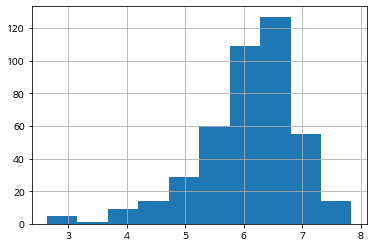

In [ ]:
#target(등록차량수) 분포확인
#분포를 확인하는 것은 타겟변수가 정상적인 데이터라는 것, 정규분포를 띨때 정확도가 올라감
new_train['등록차량수'].hist()

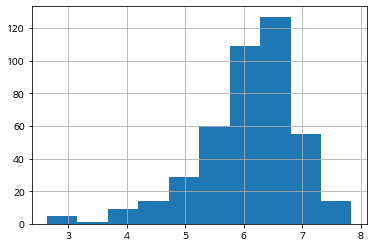

In [ ]:
np.log1p(new_train['등록차량수']).hist()

- 로그변환후 타겟변수가 더 정규분포에 가까워진것을 확인할 수 있음  
  따라서 타겟변수에 로그변환을 적용
  나머지 변수에도 동일하게 적용

In [ ]:
#타겟변수 이후의 것도 확인 - train
skew_features = new_train[features_index_unobject].apply(lambda x: skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

전용면적                            4.113837
도보 10분거리 내 지하철역 수(환승노선 수 반영)    3.563665
도보 10분거리 내 버스정류장 수              2.789813
등록차량수                           1.361853
총세대수                            1.344617
전용면적별세대수                        1.336908
dtype: float64


In [ ]:
# 타겟변수 이후의 것도 확인 - test
skew_features = new_test[[col for col in features_index_unobject if col != '등록차량수']].apply(lambda x: skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

전용면적                            4.528783
도보 10분거리 내 지하철역 수(환승노선 수 반영)    4.037509
도보 10분거리 내 버스정류장 수              2.165797
총세대수                            1.246403
전용면적별세대수                        1.245272
dtype: float64


- 보통 1이상의 왜곡이 있을때 높다고 판단, 1이상인 컬럼에 대해서 로그처리 진행

In [ ]:
new_train[features_index_unobject] = np.log1p(new_train[features_index_unobject])
new_test[[col for col in features_index_unobject if col != '등록차량수']] = np.log1p(new_test[[col for col in features_index_unobject if col != '등록차량수']])

- train 데이터에서는 변환하지 않았던 도보 컬럼이 추가됨 train도 적용

In [ ]:
new_train.drop('단지코드', axis=1, inplace=True)

In [ ]:
new_test.drop('단지코드', axis=1, inplace=True)

## 데이터 분할

In [ ]:
y_target = new_train.등록차량수
X_features = new_train.drop('등록차량수', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state=1001)

ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]} 

# 모델 생성

In [ ]:
def get_mae(model):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test , pred)
    return mae

def get_maes(models):
    maes = [ ]
    for model in models:
        mae = get_mae(model)
        maes.append(mae)
    return maes

In [ ]:
# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_maes(models)

[0.2293007790025757, 0.22322737567237605, 0.48601338122043636]

In [ ]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

In [ ]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
# visualize_coefficient(models)

In [ ]:
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    mae = -1 * grid_model.best_score_
    print('{0} 5 CV 시 최적 평균 MAE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(mae, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 MAE 값: 0.121, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 MAE 값: 0.1223, 최적 alpha:{'alpha': 0.005}


In [ ]:
def evaluate_regr(model, y):
    # MSE 는 scikit learn의 mean_absolute_error() 로 계산
    pred = model.predict(X_test)
    mse_val = mean_absolute_error(y,pred)
    print('MAE: {0:.3F}'.format(mse_val))

In [ ]:
evaluate_regr(best_rige, y_test)

MAE: 0.200


# 결과처리

In [ ]:
sorterIndex = dict(zip(sorter, range(len(sorter))))

In [ ]:
result = pd.DataFrame()
result['code'] = raw_test['단지코드'].drop_duplicates(keep='first').sort_values().reset_index(drop=True)
result['num'] = np.exp(best_rige.predict(new_test))
result['Rank'] = result['code'].map(sorterIndex)

In [ ]:
sub_ex = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/sample_submission.csv")

In [ ]:
result.sort_values('Rank').head()

,code,num,Rank
10,C1072,743.479903,0
13,C1128,1281.918928,1
44,C1456,496.607600,2
83,C1840,496.347192,3
38,C1332,960.537965,4


In [ ]:
result = result.sort_values('Rank')

In [ ]:
result.drop('Rank', axis=1, inplace=True)

In [ ]:
result.to_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/submission.csv", index=False)